In [55]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy

PROJECT_ROOT = os.path.abspath(os.pardir)
sys.path.append(PROJECT_ROOT)

from electronTransportCode.Material import Material
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.ProjectUtils import ERE

%matplotlib widget

In [56]:
bigLUT = np.load('data/ownlutv2.npy')
d = np.load('data/ownlutAxesv2.npz')
energies = d['arr_0']
stepsizeArray = d['arr_1']
densityArray = d['arr_2']

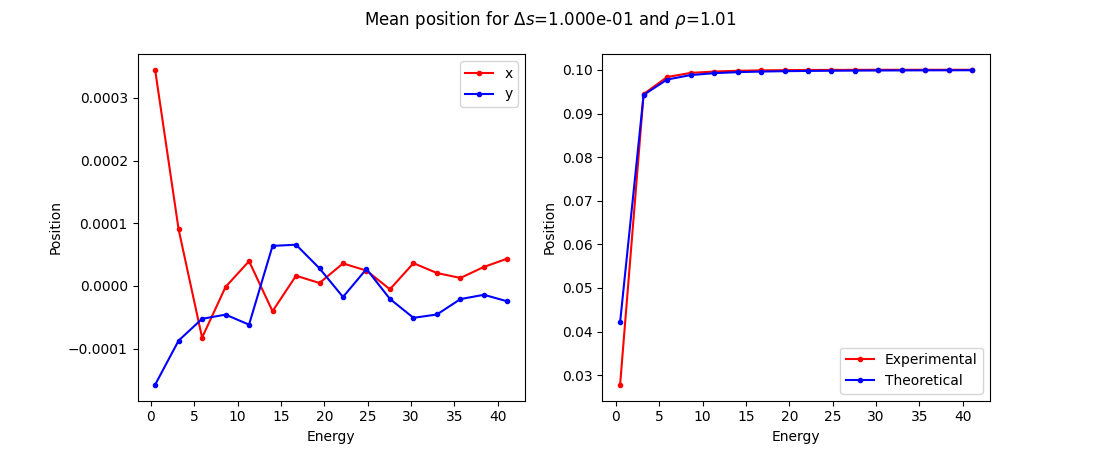

In [57]:

# Average x, y and z position
stepsizeIndex = -1
densityIndex = densityArray.size//2

# Theoretical average step
particle = SimplifiedEGSnrcElectron()
stepsize = stepsizeArray[stepsizeIndex]
material = Material(rho=densityArray[densityIndex])
EcostArray = np.array([particle.getMeanMu(energy, material) for energy in energies], dtype=float)

stepsizeDsArray = stepsize*np.array([particle.getScatteringRate(None, energy, material) for energy in energies], dtype=float)
expSum: float = 1.0 - np.exp(stepsizeDsArray*(EcostArray - 1.0))
A_coef = EcostArray*stepsize*expSum/((1 - EcostArray)*stepsizeDsArray)

# Data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle(f'Mean position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 1], '.-r', label=f'x')
ax1.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 2], '.-b', label=f'y')
ax1.set_xlabel('Energy')
ax1.set_ylabel('Position')
ax1.legend()

ax2.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 3], '.-r', label=f'Experimental')
ax2.plot(energies, A_coef, '.-b', label=f'Theoretical')
ax2.set_xlabel('Energy')
ax2.set_ylabel('Position')
ax2.legend()
# Discrepancy at lower energies due to energy dependence that is ignored by the formula.

$\Delta s$=1.000e-01 and $\rho$=1.01


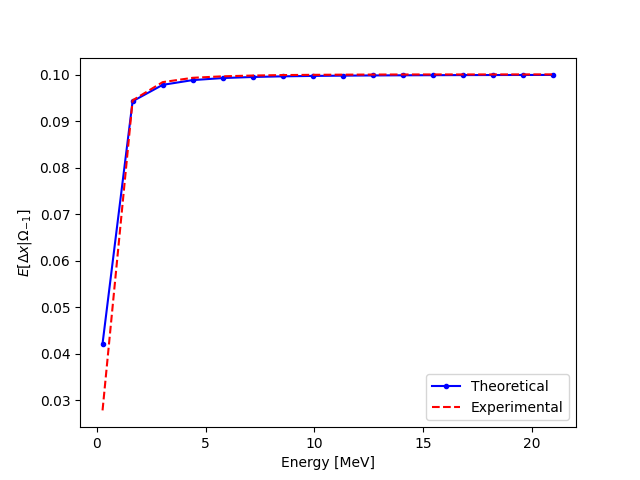

In [58]:
stepsizeIndex = -1
densityIndex = densityArray.size//2
print(f'$\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')
fig, ax = plt.subplots(1, 1)
ax.plot(energies*ERE, A_coef, '.-b', label=f'Theoretical')
ax.plot(energies*ERE, bigLUT[:, stepsizeIndex, densityIndex, 3], '--r', label=f'Experimental')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('$E[\Delta x | \Omega_{-1}]$')
ax.legend()
fig.savefig('figures/MeanKineticMotionValidation.pdf')

In [59]:

def getExpOmega2(energy: float, material: Material, omegaStart: np.ndarray) -> np.ndarray:
    u, v, w = omegaStart
    vec = np.array((0.0, 0.0, 0.0), dtype=float)
    Ecost2 = particle.getMuMoment2(energy, material)
    Esint2 = particle.getSintMoment2(energy, material)
    if not math.isclose(w, 1.0, rel_tol=1e-14):
        vec[0] = Ecost2*u**2 + Esint2*((u**2)*(w**2) + v**2)/((1-w**2)*2)
        vec[1] = Ecost2*v**2 + Esint2*((v**2)*(w**2) + u**2)/((1-w**2)*2)
        vec[2] = Ecost2*w**2 + Esint2*(1 - w**2)/2
    else: 
        vec[0] = Esint2/2
        vec[1] = Esint2/2
        vec[2] = Ecost2
    return vec

def computeVariance(energy:float, stepsize: float, density: float ) -> np.ndarray:
    omegaStart = np.array((0.0, 0.0, 1.0), dtype=float)
    material = Material(rho=density)
    sigma = particle.getScatteringRate(None, energy, material)
    a = particle.getMeanMu(energy, material)
    b = particle.getMuMoment2(energy, material)
    x = sigma*stepsize
    expectOmega2 = getExpOmega2(energy, material, omegaStart)

    # temporary variables
    expminx = math.exp(-x)
    expaminx = math.exp((a-1)*x)

    # ---- term 1 - try Saturday
    term1a1 = 4*((a**2)*(x*expaminx + 1 - expminx) - a*(x+2)*expaminx + expaminx + 2*a*expminx - expminx)/((a-1)**3)
    term1a2 = 4*(-a + a*expminx + expaminx - expminx)/((a-1)**2)
    term1a = 1 - 2*a/(a-1) + (term1a1 + term1a2)/(x**2)
    term1 = (stepsize**2)*expectOmega2*term1a 

    # ---- term 1 - try Sunday
    # term1a = 2*math.pow(stepsize, 2)*expectOmega2*((-b + expminx*b + math.exp((b-1)*x) - 1)/(b*x**2))/(b-1)
    # term1b = (a**2)*b*(b*(1-expminx) - math.exp((b-1)*x) + expminx) + (a**2)*(b*(expminx-1) + math.exp((b-1)*x) - 1) + (b-1)*(math.exp((a*b-1)*x) - expminx)
    # term1 = term1a + 4*math.pow(stepsize, 2)*expectOmega2*term1b/(b*(x**2)*(a-1)*(b-1)*(a*b-1))

    # ---- term 2 - try Saturday
    term2 = - math.pow(stepsize*a/(1-a), 2)*np.power(omegaStart, 2)*(1-math.exp(x*(a-1))+math.exp(2*x*(a-1)))/math.pow(x, 2)
    return term1 + term2



$\Delta s$=5.338e-02 and $\rho$=1.01


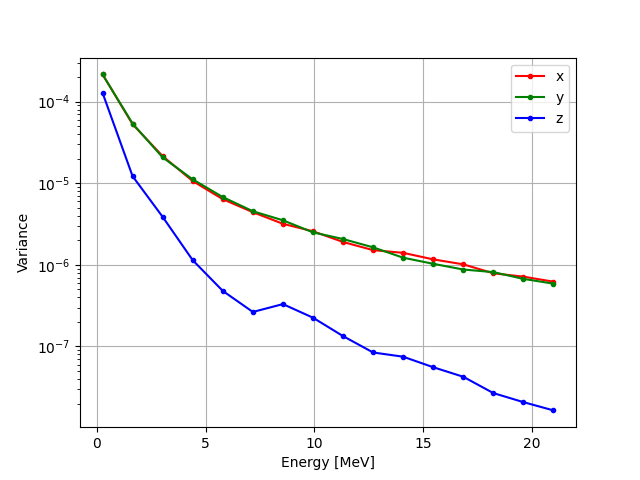

In [60]:
# Average x, y and z position
stepsizeIndex = stepsizeArray.size//2
densityIndex = densityArray.size//2

# Compute analytical variance
varx = np.zeros_like(energies)
vary = np.zeros_like(energies)
varz = np.zeros_like(energies)
for i, energyLoop in enumerate(energies):
    xtemp, ytemp, ztemp = computeVariance(energyLoop, stepsizeArray[stepsizeIndex], densityArray[densityIndex])
    varx[i] = xtemp
    vary[i] = ytemp
    varz[i] = ztemp

# Data
fig, ax1 = plt.subplots(1, 1)
# fig.suptitle(f'Variance on position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.semilogy(energies*ERE, bigLUT[:, stepsizeIndex, densityIndex, 4], '.-r', label=f'x')
ax1.semilogy(energies*ERE, bigLUT[:, stepsizeIndex, densityIndex, 5], '.-g', label=f'y')
ax1.semilogy(energies*ERE, bigLUT[:, stepsizeIndex, densityIndex, 6], '.-b', label=f'z')
ax1.set_xlabel('Energy [MeV]')
ax1.set_ylabel('Variance')
ax1.grid()
ax1.legend()
print(f'$\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')
fig.savefig('figures/VarLUTe.pdf')

$E$=1.132e+01 and $\rho$=1.01


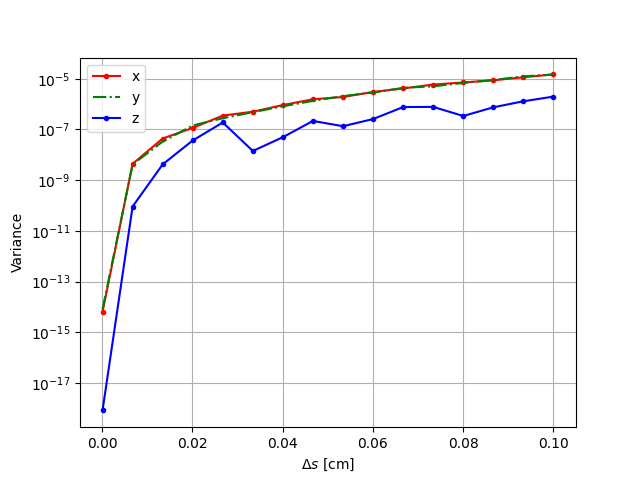

In [73]:
# Average x, y and z position
energyIndex = energies.size//2
densityIndex = densityArray.size//2

# Data
fig, ax1 = plt.subplots(1, 1)
# fig.suptitle(f'Variance on position for $\Delta s$={energies[energyIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 4], '.-r', label=f'x')
ax1.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 5], '-.g', label=f'y')
ax1.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 6], '.-b', label=f'z')
ax1.set_xlabel('$\Delta s$ [cm]')
ax1.set_ylabel('Variance')
ax1.legend()
ax1.grid()
print(f'$E$={energies[energyIndex]*ERE:.3e} and $\\rho$={densityArray[densityIndex]}')

fig.savefig('figures/VarLUTds.pdf')

$E$=1.132e+01 and \Delta s$=5.338e-02


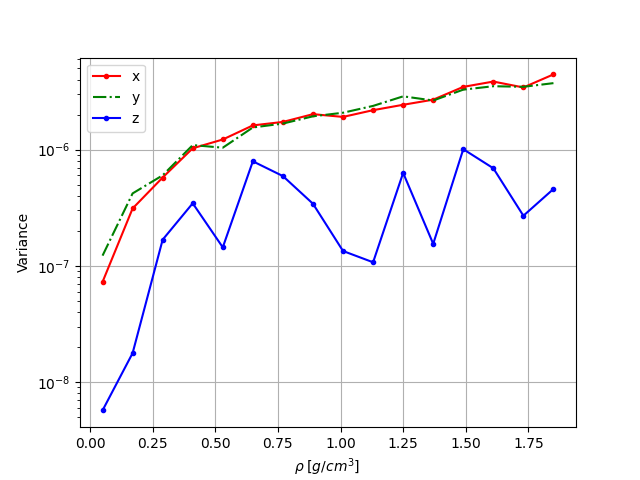

In [74]:
# Average x, y and z position
energyIndex = energies.size//2
stepsizeIndex = stepsizeArray.size//2

# Data
fig, ax1 = plt.subplots(1, 1)
# fig.suptitle(f'Variance on position for $\Delta s$={energies[energyIndex]:.3e} and $\Delta s$={stepsizeArray[stepsizeIndex]:.3e}')

ax1.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 4], '.-r', label=f'x')
ax1.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 5], '-.g', label=f'y')
ax1.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 6], '.-b', label=f'z')
ax1.set_xlabel('$\\rho \; [g/cm^3]$ ')
ax1.set_ylabel('Variance')
ax1.legend()
ax1.grid()


print(f'$E$={energies[energyIndex]*ERE:.3e} and \Delta s$={stepsizeArray[stepsizeIndex]:.3e}')
fig.savefig('figures/VarLUTrho.pdf')

Theoretical variance

In [63]:
u0, u1, u2, u3 = sy.symbols('u0, u1, u2, u3')  # type: ignore
v0, v1, v2, v3 = sy.symbols('v0, v1, v2, v3')  # type: ignore
w0, w1, w2, w3 = sy.symbols('w0, w1, w2, w3')  # type: ignore
theta0, theta1, theta2, theta3 = sy.symbols('theta0, theta1, theta2, theta3')  # type: ignore
phi0, phi1, phi2, phi3 = sy.symbols('phi0, phi1, phi2, phi3')  # type: ignore

Ecost2, Esint2 = sy.symbols('Ecost2, Esint2')  # type: ignore

In [64]:
equ1 = u0*sy.cos(theta0) + sy.sin(theta0)*(u0*w0*sy.cos(phi0) + v0*sy.sin(phi0))/sy.sqrt(1 - w0**2)
eqv1 = v0*sy.cos(theta0) + sy.sin(theta0)*(v0*w0*sy.cos(phi0) + u0*sy.sin(phi0))/sy.sqrt(1 - w0**2)
eqw1 = u0*sy.cos(theta0) - sy.sqrt(1 - w0**2)*sy.sin(theta0)*sy.cos(phi0)

In [65]:
Eu2 = (u1**2)*Ecost2 + Esint2*((u1**2)*(w1**2) + (v1**2))/(2*(1 - w1**2))
Ev2 = (u1**2)*Ecost2 + Esint2*((v1**2)*(w1**2) + (u1**2))/(2*(1 - w1**2))
Ew2 = (w1**2)*Ecost2 + Esint2*(1-w1**2)/2

In [66]:
sy.expand(Eu2.subs(u1, equ1).subs(v1, eqv1).subs(w1, eqw1))

Ecost2*u0**2*w0**2*sin(theta0)**2*cos(phi0)**2/(1 - w0**2) + 2*Ecost2*u0**2*w0*sin(theta0)*cos(phi0)*cos(theta0)/sqrt(1 - w0**2) + Ecost2*u0**2*cos(theta0)**2 + 2*Ecost2*u0*v0*w0*sin(phi0)*sin(theta0)**2*cos(phi0)/(1 - w0**2) + 2*Ecost2*u0*v0*sin(phi0)*sin(theta0)*cos(theta0)/sqrt(1 - w0**2) + Ecost2*v0**2*sin(phi0)**2*sin(theta0)**2/(1 - w0**2) + Esint2*u0**4*w0**2*sin(theta0)**2*cos(phi0)**2*cos(theta0)**2/(2*u0**2*w0**2*cos(theta0)**2 - 2*u0**2*cos(theta0)**2 - 4*u0*w0**2*sqrt(1 - w0**2)*sin(theta0)*cos(phi0)*cos(theta0) + 4*u0*sqrt(1 - w0**2)*sin(theta0)*cos(phi0)*cos(theta0) - 2*w0**4*sin(theta0)**2*cos(phi0)**2 + 4*w0**2*sin(theta0)**2*cos(phi0)**2 - 2*w0**2 - 2*sin(theta0)**2*cos(phi0)**2 + 2) + 2*Esint2*u0**4*w0*sin(theta0)*cos(phi0)*cos(theta0)**3/(-2*u0**2*sqrt(1 - w0**2)*cos(theta0)**2 - 4*u0*w0**2*sin(theta0)*cos(phi0)*cos(theta0) + 4*u0*sin(theta0)*cos(phi0)*cos(theta0) + 2*w0**2*sqrt(1 - w0**2)*sin(theta0)**2*cos(phi0)**2 - 2*sqrt(1 - w0**2)*sin(theta0)**2*cos(phi0)**2 + 